In [16]:
# 必要なライブラリのインポート
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sqlalchemy import create_engine

# PostgreSQLデータベースへの接続設定
db_config = {
    'user': 'postgres',
    'password': 'postgres',
    'host': 'localhost',
    'port': '54322',
    'database': 'postgres'
}

# SQLAlchemyエンジンの作成
engine = create_engine(f"postgresql+psycopg2://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}")

# データの読み込み
yahoomap_crawds_query = "SELECT * FROM yahoomap_crawds"
event_details_query = "SELECT * FROM event_details"
weather_history_hour_query = "SELECT * FROM weather_history_hour"

yahoomap_crawds = pd.read_sql(yahoomap_crawds_query, engine)
event_details = pd.read_sql(event_details_query, engine)
weather_history_hour = pd.read_sql(weather_history_hour_query, engine)

ariake_ = pd.read_csv('ariake.csv')
wahington_= pd.read_csv('wahington.csv')

In [18]:
def convert_time_to_hhmm(t):
    # "5時" -> hour=5, minute=00
    # "5時半" -> hour=5, minute=30
    # 数字部分(時)を抽出
    hour = int(t.split('時')[0])
    # 「半」が含まれているかで分を判定
    minute = 30 if '半' in t else 0
    
    # フォーマット：hhmm
    return f"{hour:02d}{minute:02d}"


wahington_['時間'] = wahington_['時間'].apply(convert_time_to_hhmm)
ariake_['時間'] = ariake_['時間'].apply(convert_time_to_hhmm)

wahington_ = wahington_[['日付', '時間', '合計']] 
ariake_ = ariake_[['日付', '時間', '合計']] 

/var/folders/0b/kvbdjp6d6kl4v5f97xnk5h480000gn/T/ipykernel_61985/932817055.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  + pd.to_timedelta(df['new_hour'], 'H') \
/var/folders/0b/kvbdjp6d6kl4v5f97xnk5h480000gn/T/ipykernel_61985/932817055.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  + pd.to_timedelta(df['new_hour'], 'H') \


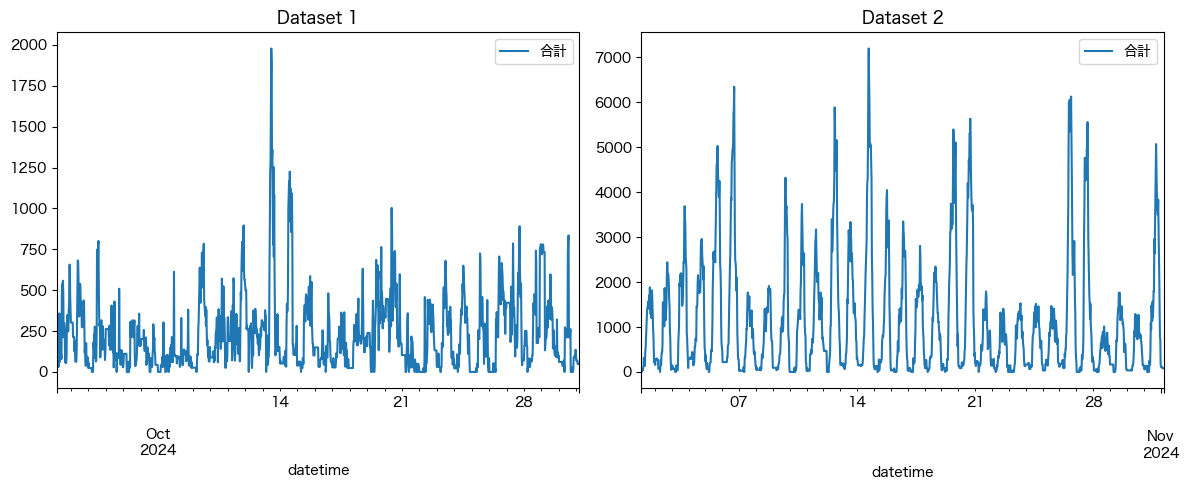

In [28]:
def preprocess_df(df):
    # 日付カラムをdatetime型へ
    df['日付'] = pd.to_datetime(df['日付'])

    # 時間文字列を分解（例: "0530"-> hour=5, minute=30  "2630"-> hour=26, minute=30）
    df['hour'] = df['時間'].str[:-2].astype(int)   # 先頭から末2文字前までが時
    df['minute'] = df['時間'].str[-2:].astype(int) # 最後の2文字が分

    # 24時を超える場合に日付を繰り上げる処理
    # 総分数=hour*60+minute -> 日跨ぎ判定
    df['total_minutes'] = df['hour']*60 + df['minute']
    df['day_offset'] = df['total_minutes'] // 1440  # 1440分=24時間
    df['remain_minutes'] = df['total_minutes'] % 1440
    df['new_hour'] = df['remain_minutes'] // 60
    df['new_minute'] = df['remain_minutes'] % 60

    # 元の日付にday_offset日を足し、hour/minuteを加算
    df['datetime'] = df['日付'] + pd.to_timedelta(df['day_offset'], 'D') \
                                + pd.to_timedelta(df['new_hour'], 'H') \
                                + pd.to_timedelta(df['new_minute'], 'm')

    # 不要な中間列削除
    df.drop(columns=['hour','minute','total_minutes','day_offset','remain_minutes','new_hour','new_minute'], inplace=True)

    return df

wahington_ = preprocess_df(wahington_)
ariake_ = preprocess_df(ariake_)

import matplotlib.pyplot as plt

# プロット
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

wahington_.plot(x='datetime', y='合計', ax=axes[0], title='Dataset 1')
ariake_.plot(x='datetime', y='合計', ax=axes[1], title='Dataset 2')

plt.tight_layout()
plt.show()

In [31]:
df = ariake_

In [32]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# データフレームを 'df' とします。
# df は以下のカラムを持つと想定:
# '日付', '時間', '合計', 'datetime'
# 'datetime'は既にpd.to_datetimeされている

# datetime特徴量の抽出
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df['minute'] = df['datetime'].dt.minute
df['dayofweek'] = df['datetime'].dt.dayofweek  # 月曜=0, 日曜=6

# 目的変数と説明変数の分離
X = df[['year','month','day','hour','minute','dayofweek']]  # datetime由来の特徴量
y = df['合計']

# 学習用・テスト用データに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ランダムフォレスト回帰モデルの作成・学習
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# テストデータで予測
y_pred = model.predict(X_test)

# モデル評価(MSE, RMSEなど)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("テストデータでのRMSE:", rmse)

# 特徴量の重要度確認
importances = model.feature_importances_
for feat, imp in zip(X.columns, importances):
    print(f"{feat}: {imp:.3f}")

テストデータでのRMSE: 303.6223053201452
year: 0.000
month: 0.000
day: 0.145
hour: 0.643
minute: 0.009
dayofweek: 0.203


テストデータでのRMSE: 106.53464192719453


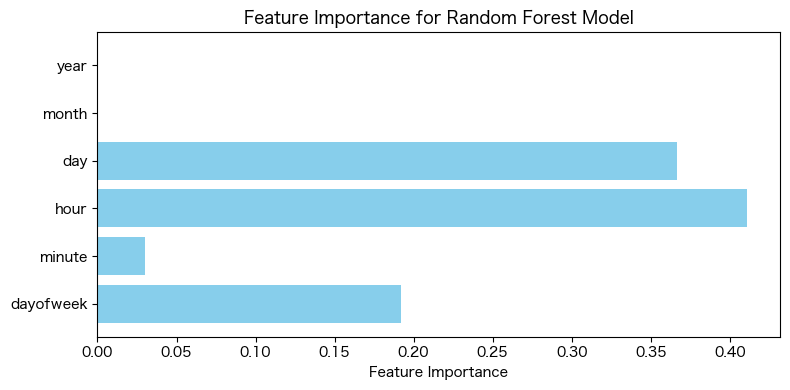

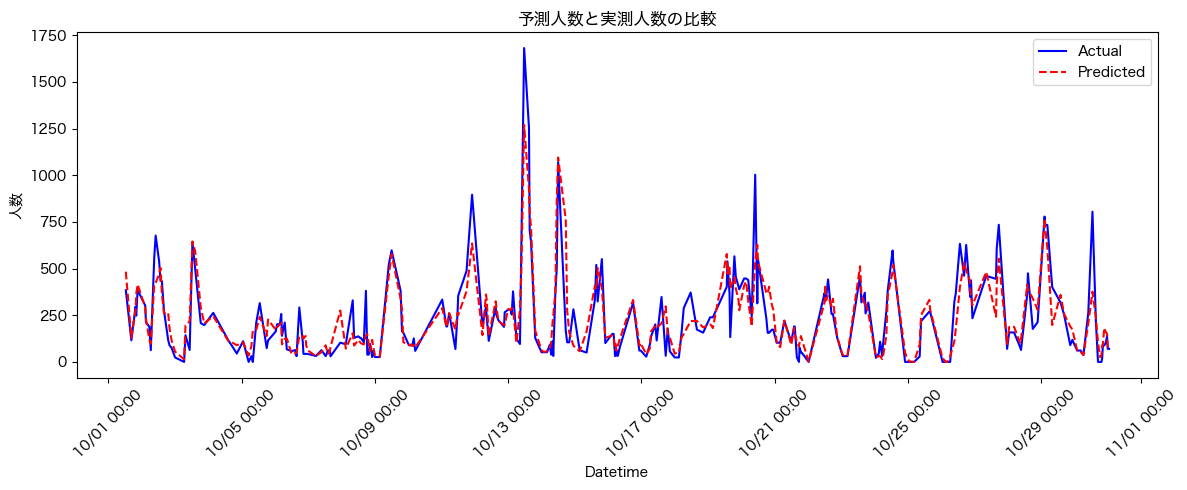

In [34]:
df = wahington_

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.font_manager as fm

# ==== データ読み込み・前処理例（dfを準備済みと仮定）====
# dfには '日付', '時間', '合計', 'datetime' カラムが存在し、
# 'datetime'はすでにpd.to_datetimeで変換済み

# datetime特徴量抽出
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df['minute'] = df['datetime'].dt.minute
df['dayofweek'] = df['datetime'].dt.dayofweek

# 目的変数と説明変数の分離
X = df[['year','month','day','hour','minute','dayofweek']]
y = df['合計']

# 学習用・テスト用データに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ランダムフォレスト回帰モデル
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 予測
y_pred = model.predict(X_test)

# RMSE計算
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("テストデータでのRMSE:", rmse)

# ==== 特徴量重要度の可視化 ====
importances = model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(8, 4))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Feature Importance for Random Forest Model")
plt.gca().invert_yaxis() # 上から重要度が高い順で並べる
plt.tight_layout()
plt.show()

# ==== 予測結果 vs 実測値の可視化 ====
# テストデータを時系列順に並べて比較するため、X_test, y_test, y_predを再構築
test_df = X_test.copy()
test_df['Actual'] = y_test
test_df['Predicted'] = y_pred

# 今回は時系列で並べ直すために、元のインデックス情報を使用（dfからdatetime取得にはX_testからは不可、再結合が必要）
# もしX_test, y_test分割前にdfにindexがあれば、そのindexで対応付けできます。
# ここではX_test, y_testがdfに対応するインデックスを保持していると仮定
test_df['datetime'] = df['datetime'].iloc[test_df.index]  # テスト用のインデックスを用いて対応付け
test_df = test_df.sort_values('datetime')

fig, ax = plt.subplots(figsize=(12, 5))

# 実測値
ax.plot(test_df['datetime'], test_df['Actual'], label='Actual', color='blue')
# 予測値
ax.plot(test_df['datetime'], test_df['Predicted'], label='Predicted', color='red', linestyle='--')

ax.set_xlabel("Datetime")
ax.set_ylabel("人数")
ax.set_title("予測人数と実測人数の比較")
ax.legend()

# 日付フォーマット調整
date_formatter = mdates.DateFormatter('%m/%d %H:%M')
ax.xaxis.set_major_formatter(date_formatter)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()